In [1]:
import bagpy
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def point_to_index(map_origins, map_resolution, map_dimensions, point):
    origin_x, origin_y = map_origins
    width, height = map_dimensions

    x, y = point[0], point[1]

    index_x = int(round((x - origin_x) / map_resolution))
    index_y = int(round((y - origin_y) / map_resolution))

    index_x = index_x if index_x < width else width - 1
    index_y = index_y if index_y < height else height - 1

    return [index_x, index_y]

def index_to_point(map_origins, map_resolution, index):
    origin_x, origin_y = map_origins

    index_x, index_y = index[0], index[1]

    x = origin_x + index_x * map_resolution
    y = origin_y + index_y * map_resolution

    return np.array([x, y])

In [3]:
def count_cells(corners, map_data, map_origins, map_resolution, map_dimensions):
    x, y = map_origins
    corner1, corner2 = corners
    
    corner1_index = point_to_index(map_origins, map_resolution, map_dimensions, corner1)
    corner2_index = point_to_index(map_origins, map_resolution, map_dimensions, corner2)
    
    exploration_data = map_data[corner1_index[1]:corner2_index[1] + 1, corner1_index[0]:corner2_index[0] + 1]
    unique, counts = np.unique(exploration_data, return_counts=True)
    d = dict(zip(unique, counts))
    return d

In [4]:
def process_bag(bag_file, map_topic):
    b = bagpy.bagreader(bag_file)
    
    clicked_point_csv = b.message_by_topic('clicked_point')
    clicked_point_df = pd.read_csv(clicked_point_csv)
    
    exploration_start_time = clicked_point_df.iloc[-1]['Time']

    point1 = np.array([clicked_point_df.iloc[0]['point.x'], clicked_point_df.iloc[0]['point.y']])
    point2 = np.array([clicked_point_df.iloc[2]['point.x'], clicked_point_df.iloc[2]['point.y']])

    exploration_width = abs(point1[0] - point2[0])
    exploration_height = abs(point1[1] - point2[1])
    exploration_area = exploration_width * exploration_height
    
    print(exploration_start_time, exploration_width, exploration_height, exploration_area)
    
    world_map_csv = b.message_by_topic(map_topic)
    world_map_df = pd.read_csv(world_map_csv)
    world_map_df = world_map_df.loc[(world_map_df['Time'] > exploration_start_time)]
    
    print("world_map_df:", world_map_df.shape)
    
    world_map_dimensions_list = world_map_df[['info.width', 'info.height']].values.tolist()
    
    print("world_map_dimensions:", world_map_dimensions_list[0], world_map_dimensions_list[-1])
    
    world_map_data_list = world_map_df.filter(like="data_", axis=1).values.tolist()
    world_map_data_list = [
        np.resize(world_map_data_list[i], (world_map_dimensions_list[i][1], world_map_dimensions_list[i][0]))
        for i in range(len(world_map_data_list))
    ]
    
    # assume point2 to be at lower right corner, and point1 to be at upper left
    corners = [point2, point1]
    # [world_map_df.iloc[0]['info.origin.position.x'],  world_map_df.iloc[0]['info.origin.position.y']]
    world_map_origins_list = world_map_df[['info.origin.position.x', 'info.origin.position.y']].values.tolist()
    world_map_resolution = world_map_df.iloc[0]['info.resolution']
    
    cell_counts = [
        count_cells(corners, world_map_data_list[i], world_map_origins_list[i], world_map_resolution, world_map_dimensions_list[i])
        for i in range(len(world_map_data_list))
    ]
    
    unknown_cells = [
        c[-1]
        for c in cell_counts
    ]
    
    unknown_area = [
        c * (world_map_resolution ** 2)
        for c in unknown_cells
    ]
    
    unknown_area_percentage = [
        c / exploration_area * 100
        for c in unknown_area
    ]
    
    world_map_df['Time'] = world_map_df['Time'] - exploration_start_time
    world_map_df['Unknown area percentage'] = unknown_area_percentage
    
    return world_map_df

In [5]:
sim_a_one_robot_df = process_bag("../bags/1_robot_turtlebot_house_1_2023-03-17-18-57-29.bag", "robot_1/map")
sim_a_two_robot_df = process_bag("../bags/2_robot_turtlebot_house_2_2023-03-17-19-08-29.bag", "map")
sim_a_three_robot_df = process_bag("../bags/3_robot_turtlebot_house_6_2023-03-17-17-47-57.bag", "map")

[INFO]  Successfully created the data folder ../bags/1_robot_turtlebot_house_1_2023-03-17-18-57-29.
1706.712 14.610249042510986 10.13204288482666 148.03166985671896
world_map_df: (61, 278545)
world_map_dimensions: [544, 512] [544, 736]
[INFO]  Successfully created the data folder ../bags/2_robot_turtlebot_house_2_2023-03-17-19-08-29.
1690.237 14.792198657989502 9.900758743286133 146.45399019551496
world_map_df: (45, 472434)
world_map_dimensions: [737, 641] [738, 641]
[INFO]  Successfully created the data folder ../bags/3_robot_turtlebot_house_6_2023-03-17-17-47-57.
1821.386 14.362606525421143 10.122361660003662 145.3834976306414
world_map_df: (21, 472434)
world_map_dimensions: [737, 641] [738, 706]


In [6]:
sim_b_one_robot_df = sim_a_one_robot_df
sim_b_two_robot_df = process_bag("../bags/2_robot_turtlebot_house_b_2_2023-04-19-16-55-30.bag", "map")
sim_b_three_robot_df = process_bag("../bags/3_robot_turtlebot_house_b_2_2023-04-19-16-01-46.bag", "map")

[INFO]  Successfully created the data folder ../bags/2_robot_turtlebot_house_b_2_2023-04-19-16-55-30.
1650.092 14.271069049835205 9.814651012420654 140.06556229829016
world_map_df: (60, 246770)
world_map_dimensions: [513, 481] [513, 481]
[INFO]  Successfully created the data folder ../bags/3_robot_turtlebot_house_b_2_2023-04-19-16-01-46.
1674.001 14.447875022888184 10.16111707687378 146.80654961960727
world_map_df: (65, 246770)
world_map_dimensions: [513, 481] [513, 481]


In [7]:
seaborn.set_style("whitegrid")

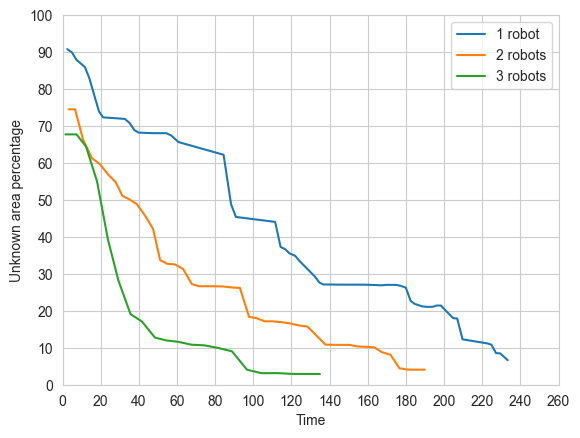

In [8]:
fig, ax = plt.subplots()

seaborn.lineplot(ax=ax, data=sim_a_one_robot_df, x='Time', y='Unknown area percentage', label="1 robot")
seaborn.lineplot(ax=ax, data=sim_a_two_robot_df, x='Time', y='Unknown area percentage', label="2 robots")
seaborn.lineplot(ax=ax, data=sim_a_three_robot_df, x='Time', y='Unknown area percentage', label="3 robots")

ax.set_xlim(0, 260)
ax.set_xticks(range(0, 261, 20))
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))

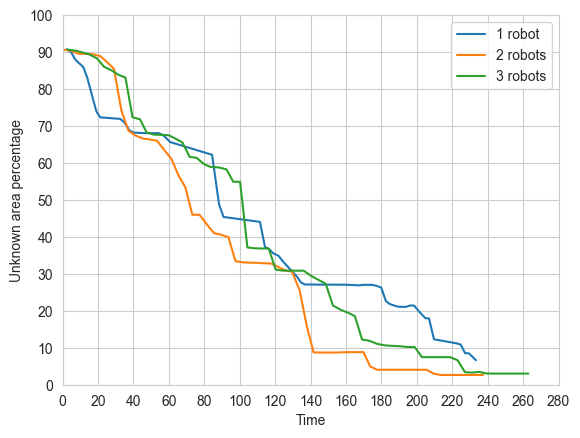

In [9]:
fig, ax = plt.subplots()

seaborn.lineplot(ax=ax, data=sim_b_one_robot_df, x='Time', y='Unknown area percentage', label="1 robot")
seaborn.lineplot(ax=ax, data=sim_b_two_robot_df, x='Time', y='Unknown area percentage', label="2 robots")
seaborn.lineplot(ax=ax, data=sim_b_three_robot_df, x='Time', y='Unknown area percentage', label="3 robots")

ax.set_xlim(0, 280)
ax.set_xticks(range(0, 281, 20))
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))

In [10]:
# fig, ax = plt.subplots()

# seaborn.lineplot(ax=ax, data=sim_a_one_robot_df, x='Time', y='Unknown area percentage', label="1 robot")
# seaborn.lineplot(ax=ax, data=sim_a_two_robot_df, x='Time', y='Unknown area percentage', label="2 robot (different starting locations)")
# seaborn.lineplot(ax=ax, data=sim_a_three_robot_df, x='Time', y='Unknown area percentage', label="3 robot (different staring locations)")
# seaborn.lineplot(ax=ax, data=sim_b_two_robot_df, x='Time', y='Unknown area percentage', label="2 robots (same staring locations)")
# seaborn.lineplot(ax=ax, data=sim_b_three_robot_df, x='Time', y='Unknown area percentage', label="3 robots (same starting locations)")

# ax.set_xlim(0, 280)
# ax.set_xticks(range(0, 281, 20))
# ax.set_ylim(0, 100)
# ax.set_yticks(range(0, 101, 10))

In [11]:
exp_a_one_robot_df = process_bag("../bags/1_robot_lab_8_2023-03-22-07-58-02.bag", "robot_1/map")
exp_a_two_robot_df = process_bag("../bags/2_robot_lab_8_2023-03-22-08-32-29.bag", "map")

[INFO]  Data folder ../bags/1_robot_lab_8_2023-03-22-07-58-02 already exists. Not creating.
1679471909.2843752 4.782826840877533 3.9787373542785645 19.02961181084558
world_map_df: (78, 173073)
world_map_dimensions: [416, 416] [416, 416]
[INFO]  Data folder ../bags/2_robot_lab_8_2023-03-22-08-32-29 already exists. Not creating.
1679473974.9243283 4.2312703132629395 4.067688703536987 17.21149045487107
world_map_df: (49, 227542)
world_map_dimensions: [475, 479] [475, 479]


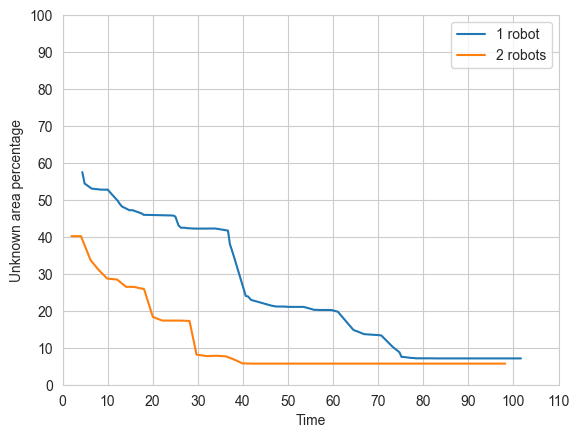

In [12]:
fig, ax = plt.subplots()

seaborn.lineplot(ax=ax, data=exp_a_one_robot_df, x='Time', y='Unknown area percentage', label="1 robot")
seaborn.lineplot(ax=ax, data=exp_a_two_robot_df, x='Time', y='Unknown area percentage', label="2 robots")
ax.set_xlim(0, 110)
ax.set_xticks(range(0, 111, 10))
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))

In [13]:
exp_a_one_robot_df = process_bag("../bags/1_robot_lab_8_2023-03-22-07-58-02.bag", "robot_1/map")
exp_b_two_robot_df = process_bag("../bags/2_robot_lab_b_2_2023-04-20-08-22-14.bag", "map")

[INFO]  Data folder ../bags/1_robot_lab_8_2023-03-22-07-58-02 already exists. Not creating.
1679471909.2843752 4.782826840877533 3.9787373542785645 19.02961181084558
world_map_df: (78, 173073)
world_map_dimensions: [416, 416] [416, 416]
[INFO]  Data folder ../bags/2_robot_lab_b_2_2023-04-20-08-22-14 already exists. Not creating.
1681978960.2098546 4.32725203037262 3.9913480281829834 17.271568858878567
world_map_df: (42, 178503)
world_map_dimensions: [418, 427] [418, 427]


In [14]:
exp_c_one_robot_df = process_bag("../bags/1_robot_lab_c_1_2023-04-20-09-38-52.bag", "robot_1/map")
exp_c_two_robot_df = process_bag("../bags/2_robot_lab_c_2_2023-04-20-09-09-30.bag", "map")

[INFO]  Data folder ../bags/1_robot_lab_c_1_2023-04-20-09-38-52 already exists. Not creating.
1681983588.1263976 3.783184051513672 4.029352188110352 15.243780935990799
world_map_df: (56, 173073)
world_map_dimensions: [416, 416] [416, 416]
[INFO]  Data folder ../bags/2_robot_lab_c_2_2023-04-20-09-09-30 already exists. Not creating.
1681981801.377485 4.410422325134277 4.00039005279541 17.643409598093967
world_map_df: (70, 180217)
world_map_dimensions: [424, 425] [424, 425]


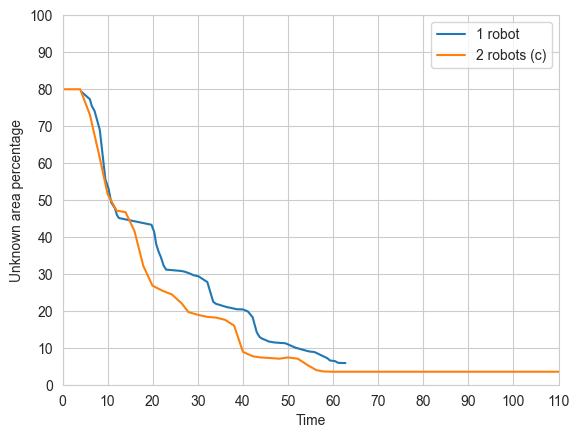

In [19]:
fig, ax = plt.subplots()

seaborn.lineplot(ax=ax, data=exp_c_one_robot_df, x='Time', y='Unknown area percentage', label="1 robot")
# seaborn.lineplot(ax=ax, data=exp_b_two_robot_df, x='Time', y='Unknown area percentage', label="2 robots (b)")
seaborn.lineplot(ax=ax, data=exp_c_two_robot_df, x='Time', y='Unknown area percentage', label="2 robots (c)")
ax.set_xlim(0, 110)
ax.set_xticks(range(0, 111, 10))
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))